<h3>TODO</h3> 
Fill in any place that says <code># YOUR CODE HERE</code> (make sure to remove the line <code>raise NotImplementedError()</code>).

<h3>Suggestions</h3>

- To speed up your code, think about how certain operations can be done at the same time.
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- Double check your code does not have $\infty$-loops, these will crash the autograder.

<h3>Rules</h3>

- Blank cells in the notebook are hidden tests. **Do not delete or alter these cells as this will cause the tests to fail automatically**.
- **Do not copy any cell**. Instead create a new cell and transfer any code into the new cell.
- Do not create multiple python notebooks (.ipynb files).
- Do not import any new python packages (this may cause hidden tests to fail).
- Each cell must run for less than 5 minutes (there exists a solution with full marks).
- **Do not plagiarise!** We take violations of this very seriously. In previous years we have identified instances of plagiarism and reported them to the Senior Teaching & Learning Administrator.
- If you are happy with your current grade you do not need to resubmit, the most recent grade from the autograder will be your final grade.
- **Only the final submission will be marked!** We will not retain marks or submissions for intermediate runs, so make sure you are happy with your final submission. Start early to take advantage of the multiple autograder runs.

---

In [129]:
import numpy as np
np.random.seed(0)
from numpy.matlib import repmat
import sys
import time
from l2distance import l2distance
import visclassifier
import matplotlib
import matplotlib.pyplot as plt
import traceback

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random

%matplotlib widget

## Introduction

In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, initially developed by Facebook's AI Research lab but now run by its own independent foundation. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays.

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [130]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # construct random w and b vectors
    gt_w = torch.randn(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.normal(size=(num_samples, 1)) * 0.02
    test_noise = np.random.normal(size=(int(num_samples * 0.1), 1)) * 0.02
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [131]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

In [132]:
lr_yTe.shape

torch.Size([100, 1])

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [133]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [134]:
def mse_loss(y_pred, y_true):
    square_diff = torch.square((y_pred-y_true))
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, **using stochastic gradient descent (SGD) as an optimizer**. We have supplied comments per line to help walk you through what each different part does.

If you have used pytorch before, for example with deep learning models, this code will look familiar.

In [135]:
def train_regression_model_sgd(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [136]:
model = train_regression_model_sgd(lr_xTr, lr_yTr, num_epochs=1000, reg_param=0.001, lr=1e-2)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.017585136111126394
epoch 200 loss 0.005431218171491137
epoch 300 loss 0.003950725922378037
epoch 400 loss 0.0034183271055554373
epoch 500 loss 0.003049092395767497
epoch 600 loss 0.0027313653843087098
epoch 700 loss 0.0024532230529946855
epoch 800 loss 0.0022093477998595353
epoch 900 loss 0.001995485117264076
epoch 1000 loss 0.0018079401473855413
avg test error 0.0014218939210399043


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

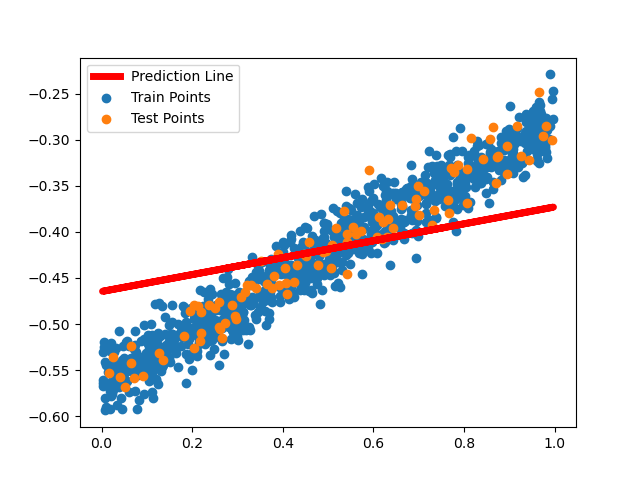

In [137]:
plt.figure()
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

**Note that this might not have converged!** Try re-running the cell above multiple times to see what different results you might get. Adjusting the number of epochs, the regularisation strength, and the learning rate will all affect the solution.

Instead, for this assignment, we will use an optimiser that might be unfamiliar to you in pytorch: (L-BFGS)[https://en.wikipedia.org/wiki/Limited-memory_BFGS], an approximate second-order algorithm. While second-order optimisers are not generally preferred for deep learning models, for models which are actually convex or for which mini-batching is unnecessary, this can be far more efficient.

The pytorch interface for running the optimiser with L-BFGS is a bit different, and requires defining a `closure` function that executes on each step.

In [138]:
def train_regression_model_lbfgs(xTr, yTr, num_epochs, reg_param):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    # * for the optimizer, we use the "default" learning rate of 1.0
    # * the `line_search_fn` helps determine a step size, but is inappropriate 
    #   for stochastic objectives (we are doing batch updates here)
    optimizer = optim.LBFGS(model.parameters(), lr=1.0, line_search_fn='strong_wolfe') # create an optimizer

    def closure():
        """ Function called on every optimiser step """
        optimizer.zero_grad()
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w) # compute loss
        loss.backward()  # compute the gradient wrt loss
        return loss # return loss
    
    for epoch in range(num_epochs):
        loss = optimizer.step(closure)    
        print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In the following cell, we train the model with L-BFGS and plot the result. Note that although we run it for 10 "epochs" (optimiser iterations, or `step`s), the model had actually converged in just one! Each optimiser `.step` will actually call the closure multiple times.

We don't use a learning rate parameter here, but you might want to in other applications (e.g. where the objective is not actually convex, or where minibatches are used in each step). We do include a line

epoch 1 loss 0.6831833149572917
epoch 2 loss 0.0004714139679817672
epoch 3 loss 0.0004714139679817672
epoch 4 loss 0.0004714139679817672
epoch 5 loss 0.0004714139679817672
epoch 6 loss 0.0004714139679817672
epoch 7 loss 0.0004714139679817672
epoch 8 loss 0.0004714139679817672
epoch 9 loss 0.0004714139679817672
epoch 10 loss 0.0004714139679817672
avg test error 0.0001691605469969716


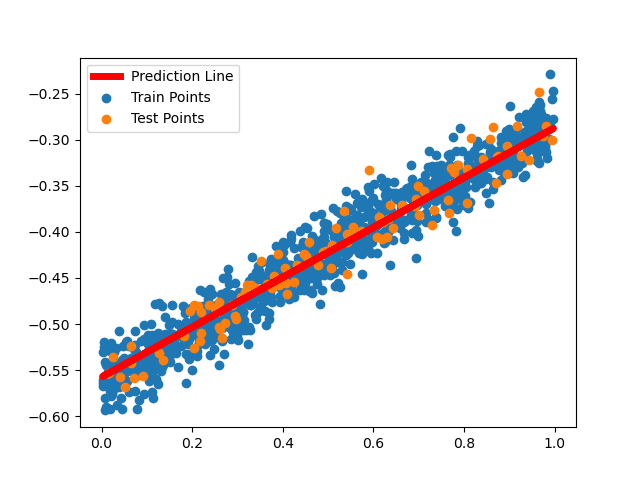

In [139]:
model = train_regression_model_lbfgs(lr_xTr, lr_yTr, num_epochs=10, reg_param=0.001)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

plt.figure()
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

## Linear classification

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [140]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming, this is gradient descent optimization so the constraints are something we do not worry about.</p>

To warm up, implement <code>hinge_loss</code>, which calculates the loss described in $\sum_{i=1}^n \xi_i$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [141]:
def hinge_loss(y_pred, y_true):
    # YOUR CODE HERE
    # raise NotImplementedError()
    margin = 1 - y_true * y_pred
    losses = torch.clamp(margin, min=0)
    return losses.sum()

Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input x. Hint: It <b>should</b> look very similar to what you have done before.

In [142]:
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        # YOUR CODE HERE
        # raise NotImplementedError()
        super().__init__()
        self.w = nn.Parameter(torch.zeros(dim))
        self.b = nn.Parameter(torch.zeros(1)) 

    def forward(self, x):
        # YOUR CODE HERE
        # raise NotImplementedError()
        return x @ self.w + self.b

Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function (https://www.w3schools.com/python/python_lambda.asp) <code>svmclassify</code> that produces a forward pass of your trained model.

In [143]:
def primalSVM(xTr, yTr, num_epochs=10, C=1):
    ndims = xTr.shape[1]
    
    model = LinearClassifier(ndims)  # initialize the model
    optimizer = optim.LBFGS(model.parameters(), lr=1, line_search_fn='strong_wolfe') # create an optimizer

    def closure():
        """ Function called on every optimiser step """
        optimizer.zero_grad()
        pred = model.forward(xTr)  # compute model predictions
        loss = torch.sum(model.w ** 2) + hinge_loss(pred, yTr) * C # compute loss
        
        loss.backward()  # compute the gradient wrt loss
        return loss # return loss
    
    for epoch in range(num_epochs):
        loss = optimizer.step(closure)    
        print('epoch {} loss {}'.format(epoch+1, loss.item()))

    def svmclassify(x):
        scores = model(x)
        # return torch.sign(scores)
        return scores.squeeze(-1)

    return svmclassify

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

epoch 1 loss 1000.0
epoch 2 loss 59.97380065917969
epoch 3 loss 59.95154571533203
epoch 4 loss 59.95154571533203
epoch 5 loss 59.95154571533203
epoch 6 loss 59.95154571533203
epoch 7 loss 59.95154571533203
epoch 8 loss 59.95154571533203
epoch 9 loss 59.95154571533203
epoch 10 loss 59.95154571533203


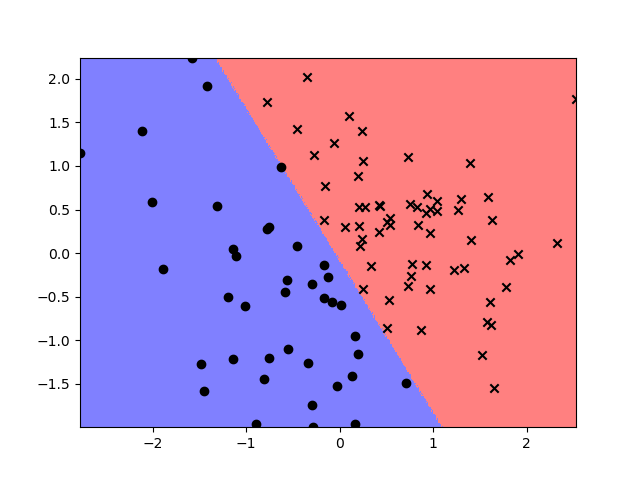

Training error: 0.0%


In [144]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

In [145]:
yTr.shape

torch.Size([100])

In [146]:
fun(xTr).shape

torch.Size([100])

In [147]:
# Hidden Test 1: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if the signs of predictions are correct

In [148]:
# Hidden Test 2: testCase_Primal
# ------------------------------
# Given a fixed training set, this tests if points farther from the decision boundary have larger predictions.

<h3>Spiral data set</h3>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [149]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
    
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

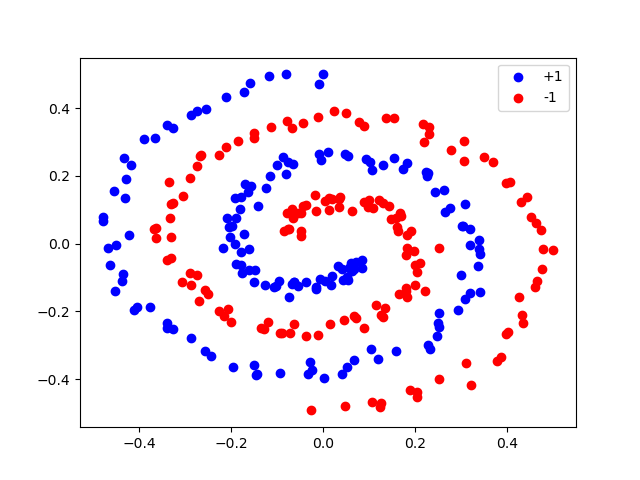

In [150]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

epoch 1 loss 3000.0
epoch 2 loss 2610.99609375
epoch 3 loss 2610.99609375
epoch 4 loss 2610.99609375
epoch 5 loss 2610.99609375
epoch 6 loss 2610.99609375
epoch 7 loss 2610.99609375
epoch 8 loss 2610.99609375
epoch 9 loss 2610.99609375
epoch 10 loss 2610.99609375


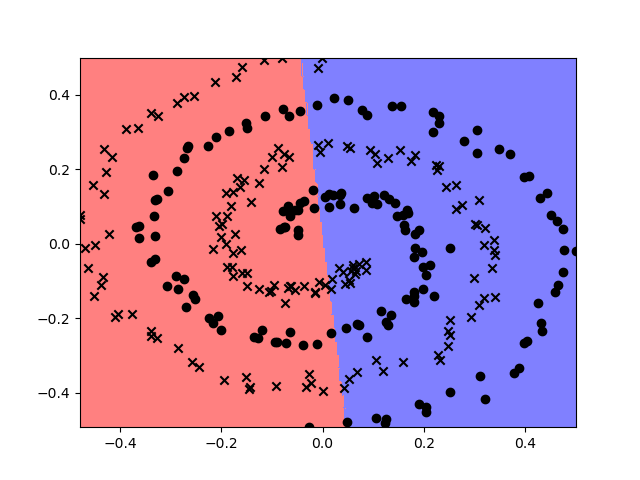

Training error: 41.0%


In [151]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

## Implementing a kernelized SVM

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [152]:
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    if kernel_type == "linear":
        K = X @ Z.T

    elif kernel_type == "polynomial":
        K = (X @ Z.T + 1) ** kpar

    elif kernel_type == "rbf":
        distance = l2distance(X, Z)
        K = torch.exp(-kpar * (distance ** 2))
   
    return K

In [153]:
# Hidden Test 3: testCase_computeK_linear
# ---------------------------------------
# This tests whether the linear kernel is computed properly on an example dataset.

In [154]:
# Hidden Test 4: testCase_computeK_polynomial
# -------------------------------------------
# This tests whether the polynomial kernel is computed properly on an example dataset.

In [155]:
# Hidden Test 5: testCase_computeK_rbf
# ------------------------------------
# This tests whether the rbf kernel is computed properly on an example dataset.

<h3>Additional Testing</h3>
<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

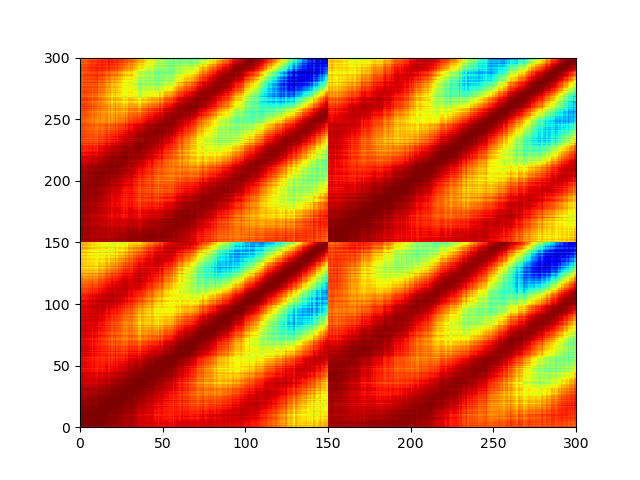

In [156]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

In [157]:
yTe.shape

torch.Size([300])

Remember that the SVM optimization has the following dual formulation: (1)
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal (2)
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$. However, after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$, (2) can be rewritten as follows (see https://arxiv.org/pdf/1404.1066.pdf for details):
$$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
where $k_i$ is the kernel matrix row corresponding to the ith training example. Notice that there are two relaxations: 1. the $\beta_i$ are unconstrained, in contrast to $\alpha_i$ in (1), which must satisfy $0 \leq \alpha_i \leq C$; and 2. the squared hinge loss is used in place of the more common absolute hinge loss.


<p>
    Implement the module 
    <pre>
    KernelizedSVM(dim, kernel_type, kpar=0)
    </pre>
    This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.
</p>

In [158]:
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        # YOUR CODE HERE
        # raise NotImplementedError()
        super(KernelizedSVM, self).__init__()
        self.beta = nn.Parameter(torch.zeros(dim))
        self.b = nn.Parameter(torch.zeros(1))
        self.kernel_type = kernel_type
        self.kpar = kpar
    
    def forward(self, xTr, x):
        # YOUR CODE HERE
        # raise NotImplementedError()
        K = computeK(self.kernel_type, xTr, x, self.kpar)
        return K.t() @ self.beta + self.b
        

<p>
    Implement the function 
    <pre>
    kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
    </pre>
    It should implement the loss function described above for the equivalent primal formulation of the dual:
    $$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
  You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find two functions especially helpful 
* <code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
* <code>torch.square(x)</code> Returns a new tensor with the square of the elements of input.
</p>

In [159]:
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    # YOUR CODE HERE
    # raise NotImplementedError()
    beta = kernelizedSVM.beta
    b = kernelizedSVM.b

    pred = kernel_mat @ beta + b

    margin = 1 - yTr * pred
    hinge_loss = 0.5 * C * (torch.square(F.relu(margin))).sum()                        

    reg = 0.5 * (beta @ (kernel_mat @ beta))
    cumulative_loss = reg + hinge_loss
    
    return cumulative_loss

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>kpar</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.
</p>

In [160]:
def dualSVM(xTr, yTr, kernel_type, num_epochs=50, C=1, kpar=0):
    # YOUR CODE HERE
    # raise NotImplementedError()
    n = xTr.shape[0]
    kernel_mat = computeK(kernel_type, xTr, xTr, kpar) 
    
    model = KernelizedSVM(dim=n, kernel_type=kernel_type, kpar=kpar)
    optimizer = optim.LBFGS(model.parameters(), lr=1e-2, line_search_fn='strong_wolfe')

    def closure():
        """ Function called on every optimiser step """
        optimizer.zero_grad()
        loss = kernelsvm_loss(model, kernel_mat, yTr, C)
        loss.backward()
        return loss

    for epoch in range(num_epochs):
        loss = optimizer.step(closure)

    def svmclassify(x):
        scores = model(xTr, x)
        return torch.sign(scores)

    return svmclassify

<h3>Testing</h3>
<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

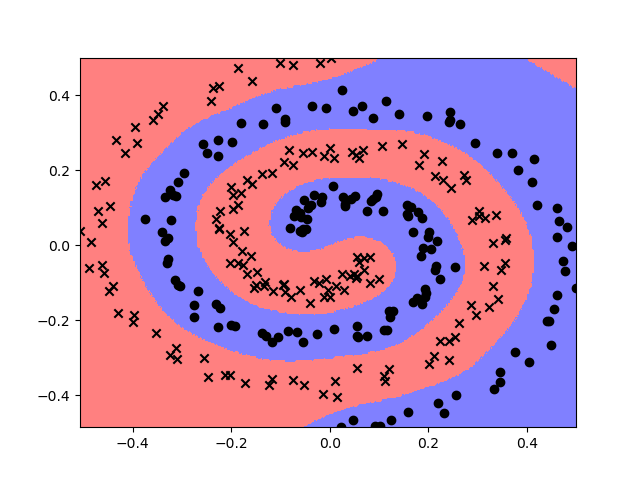

Training error: 0.0000
Testing error: 0.0000


In [161]:
# plt.figure()

xTr,yTr,xTe,yTe=spiraldata()

# poly kernel parameters that don't blow up vvv
# ktype="poly"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=50, C=5.0, kpar=20)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# linear kernel parameters that also don't blow up vvv
# ktype="linear"
# svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=10, C=0.1)
# visclassifier.visclassifier(svmclassify,xTr,yTr)

# # rbf kernel with parameters that achieve perfect accuracy vvv 
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=20, C=1, kpar=100)
visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=torch.mean((torch.sign(predsTe)!=yTe).float())
print("Testing error: %2.4f" % testingerr)

<h3>Testing Hint</h3> Create a dataset where you know what some of the optimal values of $\alpha$ will be, and test to make sure that the solution gets those values of $\alpha$ correct (recall from the lecture that the $\alpha$ values associated with certain data points are guaranteed to have a specific optimal value).

In [162]:
# Hidden Test 6: testCase_dualSVM_easy_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies an example dataset.

In [163]:
# Hidden Test 7: testCase_dualSVM_hard_dataset
# --------------------------------------------
# This tests whether the function from dualSVM correctly classifies a hard example dataset.

In [164]:
# Hidden Test 8: testCase_dualSVM_hard_dataset2
# ---------------------------------------------
# This tests whether the function from dualSVM correctly classifies an even harder example dataset.

## Cross-validation

SVMs are pretty sensitive to hyper-parameters. We ask you to implement a cross-validation function. <code>cross_validation</code> which takes training data <code>xTr</code>, training labels <code>yTr</code>, validation data <code>xValid</code>, validation labels <code>yValid</code>, kernel type <code>ktype</code>, list of possible C values <code>CList</code>, list of kernal parameter values for kernel generation <code>kparList</code>.


In [165]:
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,kparList):
    """
    function best_C,best_kpar,error_matrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,kparList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        kparList | The list of values to try for the kernel parameter kpar- degree for poly, inverse width for rbf (bx1)
    
    Output:
        best_C       | the best C parameter
        best_kpar    | the best kpar parameter
        error_matrix | the test error rate for each given (C, kpar) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    # YOUR CODE HERE
    # raise NotImplementedError()

    error_matrix = torch.zeros(len(CList), len(kparList))

    for i, C in enumerate(CList):
        for j, kpar in enumerate(kparList):
            svmclassify = dualSVM(xTr, yTr, ktype, C=C, kpar=kpar)
            preds = svmclassify(xValid)

            preds = torch.sign(preds)
            error = torch.mean((preds != yValid).float())
            error_matrix[i, j] = error

            print("The error is:", str(error))
            print("The kpar is:", kpar)

    min_val = error_matrix.min()
    pos = torch.nonzero(error_matrix == min_val)
    best_i = pos[0][0].item()
    best_j = pos[0][1].item()
    
    best_C = CList[best_i]
    best_kpar = kparList[best_j]
    
    return best_C, best_kpar, error_matrix

<h3>Testing</h3>

In [166]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
kparList=(np.linspace(0.1,0.5,5))
print(kparList)
best_C,best_kpar,error_matrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,kparList)
print("best C =", best_C)
print("best kpar =", best_kpar)
print("error_matrix =\n", error_matrix)

[0.1 0.2 0.3 0.4 0.5]
The error is: tensor(0.4200)
The kpar is: 0.1
The error is: tensor(0.4100)
The kpar is: 0.2
The error is: tensor(0.4100)
The kpar is: 0.30000000000000004
The error is: tensor(0.4200)
The kpar is: 0.4
The error is: tensor(0.4200)
The kpar is: 0.5
The error is: tensor(0.4100)
The kpar is: 0.1
The error is: tensor(0.4200)
The kpar is: 0.2
The error is: tensor(0.4200)
The kpar is: 0.30000000000000004
The error is: tensor(0.4200)
The kpar is: 0.4
The error is: tensor(0.4200)
The kpar is: 0.5
The error is: tensor(0.4100)
The kpar is: 0.1
The error is: tensor(0.4200)
The kpar is: 0.2
The error is: tensor(0.4200)
The kpar is: 0.30000000000000004
The error is: tensor(0.4200)
The kpar is: 0.4
The error is: tensor(0.4200)
The kpar is: 0.5
The error is: tensor(0.4200)
The kpar is: 0.1
The error is: tensor(0.4200)
The kpar is: 0.2
The error is: tensor(0.4200)
The kpar is: 0.30000000000000004
The error is: tensor(0.4200)
The kpar is: 0.4
The error is: tensor(0.4200)
The kpar is

In [167]:
# Hidden Test 9: testCase_cv
# ---------------------------
# This tests whether the best hyperparameters found by cross validation are correct for an example dataset.

<h3>Competition</h3>


We ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get full credit for the competition if you can beat the base benchmark of <b>46% error</b> (you will get partial credit if you beat <b>50% error</b>).

In [168]:
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    # ----- 1) Split into train/valid -----
    n = xTr.shape[0]
    indices = torch.randperm(n)
    n_train = int(0.8 * n)
    
    train_indices = indices[:n_train]
    valid_indices = indices[n_train:]

    X_train, y_train = xTr[train_indices], yTr[train_indices]
    X_valid, y_valid = xTr[valid_indices], yTr[valid_indices]

    # ----- 2) Define search ranges for hyperparameters -----
    chosen_kernel = 'rbf'
    C_candidates = 2.0 ** np.linspace(-1, 6, 7)
    kpar_candidates = np.linspace(0.05, 5.0, 6)
    

    # ----- 3) Find best (C, kpar) via cross_validation -----
    best_C, best_kpar, _ = cross_validation(
        X_train, y_train,
        X_valid, y_valid,
        ktype=chosen_kernel,
        CList=C_candidates,
        kparList=kpar_candidates
    )

    # ----- 4) Train final model on the full dataset using the best hyperparameters -----
    final_model = dualSVM(
        xTr, yTr,
        kernel_type=chosen_kernel,
        num_epochs=50,
        C=best_C,
        kpar=best_kpar
    )

    def svmclassify(xTe):
        scores = final_model(xTe)
        return scores

    return svmclassify

In [169]:
# Hidden Test 11: competition
# ---------------------------
# This tests the error rate of your classifier on the competition datasets 
# (remember each cell in this notebook should run in < 5 minutes!)

In [170]:
spiral_xTr,spiral_yTr,spiral_xTe,spiral_yTe=load_competitionBatch('spiral')
spiral_yTr.shape

NameError: name 'load_competitionBatch' is not defined

In [ ]:
XOR_xTr,XOR_yTr,XOR_xTe,XOR_yTe=load_competitionBatch('XOR')
XOR_xTr.shape

In [ ]:
# Prints out the summary of tests passed/failed.